<a href="https://colab.research.google.com/github/Hanh42/AI---UEH-K50/blob/main/AMaGo%20nh%C3%B3m%2011.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phân bố dữ liệu: {np.int64(0): np.int64(241), np.int64(1): np.int64(29), np.int64(2): np.int64(30)}
Kết quả dự đoán: [0 0 2 1 0 0 0 0 0 0]
Thực tế: [0 0 2 1 2 2 0 0 0 0]
Độ chính xác mô hình: 82.22%


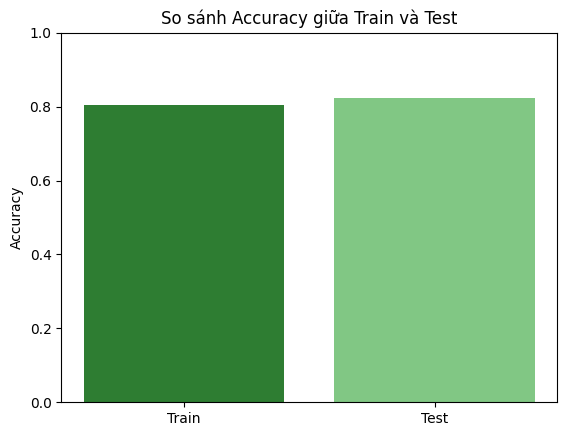

Dự đoán quả mới thuộc: Hạng II


In [ ]:
# Cell 0: Import thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Cell 1: Sinh dữ liệu mẫu giả lập theo tiêu chuẩn TCVN với khoảng cân nặng mới

np.random.seed(42)
n_samples = 300

sizes = np.random.choice([0,1,2], n_samples)
weights = np.random.normal(350, 120, n_samples).clip(100, 800)   # trọng lượng 100–800g
defects = np.random.choice([0,1,2], n_samples)
ripeness = np.random.choice([0,1,2], n_samples)
stems = np.random.choice([0,1], n_samples, p=[0.2,0.8])
colors = np.random.choice([0,1], n_samples, p=[0.2,0.8])

X = np.column_stack([sizes, weights, defects, ripeness, stems, colors])

y = []
for size, w, d, r, s, c in X:
    # Không đạt: cân nặng dưới 250 hoặc có lỗi nặng / cuống hỏng / màu sai / quá non
    if w < 250 or d == 2 or s == 0 or c == 0 or r == 0:
        y.append(0)  # Không đạt

    # Hạng I: 400–800 g, lỗi <= 1, chín vừa hoặc quá chín, cuống đạt, màu chuẩn
    elif 400 <= w <= 800 and d <= 1 and r in [1,2] and s == 1 and c == 1:
        y.append(1)  # Hạng I

    # Hạng II: còn lại nằm trong 250–399 hoặc chưa đạt chuẩn Hạng I
    else:
        y.append(2)  # Hạng II
y = np.array(y)

# In thống kê tỷ lệ từng loại để kiểm tra
unique, counts = np.unique(y, return_counts=True)
print("Phân bố dữ liệu:", dict(zip(unique, counts)))

# Cell 2: Chia tập dữ liệu & scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Cell 3 (dùng Perceptron)
from sklearn.linear_model import Perceptron

model = Perceptron(max_iter=1000,eta0=0.1, random_state=42)
model.fit(X_train_scaled, y_train)


# Cell 4: Dự đoán và tính độ chính xác
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)

print("Kết quả dự đoán:", y_pred[:10])
print("Thực tế:", y_test[:10])
print(f"Độ chính xác mô hình: {acc*100:.2f}%")

# Cell 5: Vẽ biểu đồ accuracy so sánh (train/test)
train_acc = accuracy_score(y_train, model.predict(X_train_scaled))
test_acc  = accuracy_score(y_test, y_pred)

plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['#2E7D32','#81C784'])
plt.ylabel("Accuracy")
plt.title("So sánh Accuracy giữa Train và Test")
plt.ylim(0, 1)
plt.show()

# Cell 6: Dự đoán cho một mẫu mới (giả lập input từ người dùng)
# Ví dụ: quả TB, 280g, lỗi nhẹ, chín vừa, cuống đạt, màu chuẩn
new_sample = np.array([[1, 280, 0, 1, 1, 1]])
new_sample_scaled = scaler.transform(new_sample)

pred = model.predict(new_sample_scaled)[0]
classes = {0: "Không đạt", 1: "Hạng I", 2: "Hạng II"}
print("Dự đoán quả mới thuộc:", classes[pred])


In [ ]:
# Cell 7 — UI đồng bộ luật Cell 1 + màu sắc hài hòa
!pip install gradio -q
import gradio as gr
import numpy as np

# ===== Bảng màu dịu, không quá tương phản =====
PALETTE = {
    "green": "#2E7D32",       # xanh lá đậm
    "green-soft": "#81C784",  # xanh lá nhạt hài hòa
    "amber": "#FF9800",       # cam chữ AMaGo
    "amber-soft": "#FFE082",  # vàng nhạt êm
    "yellow-soft": "#FFF59D", # vàng rất nhẹ
    "blue-soft": "#BBDEFB",   # xanh dương nhạt
    "border": "#CDE9CF",      # viền xanh lá rất nhẹ
    "bg-soft": "#F9FCF9"      # nền mềm
}

def classify_mango(size, weight, defect, ripeness, stem, color):
    mapping = {
        "Nhỏ": 0, "Trung bình": 1, "Lớn": 2,
        "Nhẹ": 0, "Vừa": 1, "Nặng": 2,
        "Quá non": 0, "Chín vừa": 1, "Quá chín": 2,
        "Không đạt": 0, "Đạt": 1,
        "Sai": 0, "Chuẩn": 1
    }

    try:
        w = float(weight)
    except:
        return "<div style='padding:14px; border-radius:12px; background:#FFF3CD; color:#795548; text-align:center;'>⚠️ Vui lòng nhập trọng lượng hợp lệ (100–800g).</div>"

    # Chuẩn hóa input như lúc train
    sample = np.array([[mapping[size], w, mapping[defect],
                        mapping[ripeness], mapping[stem], mapping[color]]])
    sample_scaled = scaler.transform(sample)

    pred = model.predict(sample_scaled)[0]
    classes = {
        0: ("❌ XOÀI KHÔNG ĐẠT", PALETTE['blue-soft'], """
            Trọng lượng quá nhỏ, lỗi nặng, cuống/màu/độ chín không phù hợp.<br>
            👉 Không đạt tiêu chuẩn tiêu thụ thương mại, nên dùng để chế biến công nghiệp.
        """),
        1: ("🥭 XOÀI LOẠI 1", PALETTE['amber-soft'], """
            Trọng lượng nặng, size chuẩn, độ chín đạt, màu sắc & cuống đẹp.<br>
            ✅ Đủ điều kiện xuất khẩu, giá trị thương mại cao.
        """),
        2: ("🥭 XOÀI LOẠI 2", PALETTE['green-soft'], """
            Trọng lượng vừa, hình thức cơ bản đạt nhưng chưa đủ chuẩn xuất khẩu.<br>
            👉 Phù hợp tiêu thụ nội địa, giá trị thương mại trung bình.
        """)
    }

    title, bg, desc = classes[pred]
    return f"""
    <div style='background:{bg}; color:{PALETTE['green']};
                font-size:24px; font-weight:800; padding:18px; border-radius:16px; text-align:center;'>
        {title}
        <div style='font-size:15px; font-weight:500; color:#444; margin-top:6px;'>
            {desc}
        </div>
    </div>
    """



# ===== CSS tinh gọn, bo góc, nhẹ nhàng =====
custom_css = f"""
:root {{
  --green: {PALETTE['green']};
  --green-soft: {PALETTE['green-soft']};
  --amber: {PALETTE['amber']};
  --amber-soft: {PALETTE['amber-soft']};
  --blue-soft: {PALETTE['blue-soft']};
  --border: {PALETTE['border']};
  --bg-soft: {PALETTE['bg-soft']};
}}
.gradio-container {{
  font-family: Inter, system-ui, Roboto, Arial, sans-serif;
}}
.input-box input {{
  font-size: 18px !important;
  padding: 12px 14px !important;
  border-radius: 12px !important;
}}
.input-box {{
  background: #FFFFFF;
  border: 1.5px solid var(--border);
  border-radius: 14px;
  padding: 10px;
}}
.option-card label {{
  border: 1.5px solid var(--border) !important;
  border-radius: 12px !important;
  padding: 10px 12px !important;
  background: #FFFFFF !important;
  color: #333333 !important;       /* chữ mặc định */
  font-weight: 500;
  transition: 0.25s;
}}

.option-card input:checked + label {{
  background: #E8F5E9 !important;  /* xanh lá rất nhạt */
  border-color: var(--green) !important;
  color: var(--green) !important;  /* chữ xanh lá đậm khi chọn */
  font-weight: 600;
}}

.option-card label:hover {{
  background: #F1F8E9 !important;  /* hiệu ứng hover */
}}

.gr-button {{
  border-radius: 12px !important;
  font-weight: 700 !important;
}}
"""
# ===== Tiêu đề đậm hơn, chữ cam + 2 trái xoài =====
# ===== Tiêu đề đậm hơn, chữ cam + 2 trái xoài =====
title_html = f"""
<div style='background:{PALETTE['blue-soft']}; padding:16px; border-radius:16px; text-align:center;'>
  <h1 style='color:{PALETTE['amber']}; margin:0; font-weight:900; letter-spacing:0.5px;'>🥭 AMaGo 🥭</h1>
  <p style='margin:6px 0 0; color:{PALETTE['green']}; font-weight:600;'>Hệ thống phân loại chất lượng xoài số 1 Việt Nam</p>
</div>
"""




with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:
    gr.HTML(title_html)

    # Ô nhập cân nặng (để mặc định 320g để thử ngay Loại 2)
    weight = gr.Number(label="⚖️ Trọng lượng (g)", value=320, elem_classes="input-box")
    tip_html = """
<div style='padding:10px; background:#FFFDE7; border-radius:12px;
            color:#555; margin:8px 0; text-align:center;'>
  💡 Nhập trọng lượng để hệ thống đánh giá chính xác.
</div>
"""


    gr.HTML(tip_html)

    with gr.Row():
        size = gr.Radio(choices=["Nhỏ","Trung bình","Lớn"], label="📏 Size", value="Trung bình", elem_classes="option-card")
        defect = gr.Radio(choices=["Nhẹ","Vừa","Nặng"], label="🔎 Lỗi", value="Nhẹ", elem_classes="option-card")
    with gr.Row():
        ripeness = gr.Radio(choices=["Quá non","Chín vừa","Quá chín"], label="🍃 Độ chín", value="Chín vừa", elem_classes="option-card")
        stem = gr.Radio(choices=["Không đạt","Đạt"], label="🌿 Cuống", value="Đạt", elem_classes="option-card")
    with gr.Row():
        color = gr.Radio(choices=["Sai","Chuẩn"], label="🥭 Màu sắc", value="Chuẩn", elem_classes="option-card")

    btn = gr.Button("🔍 Phân loại")
    output = gr.HTML()

    btn.click(classify_mango, [size, weight, defect, ripeness, stem, color], output)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d9e6ac8af5f130d4b2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
